In [1]:
reset -sf

In [2]:
import sys
import os
import numpy as np 
import pandas as pd
from pathlib import Path

# univariate mlp example
from numpy import array

from keras import optimizers
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Conv1D, MaxPooling1D, Flatten, Dropout, LSTM

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.externals import joblib 

import matplotlib.pyplot as plt

/home/administrador/anaconda3/envs/deeplung/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
PATH = Path("../../data/")

In [4]:
scaler = joblib.load(PATH/'train_scaler_x.pkl')

/home/administrador/anaconda3/envs/deeplung/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator StandardScaler from version 0.20.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [5]:
dfX_Train = np.load(PATH/'train_x.npy')
dfX_Val = np.load(PATH/'val_x.npy') 
dfX_Test = np.load(PATH/'test_x.npy')
dfY_Train = np.load(PATH/'train_y.npy')
dfY_Val = np.load(PATH/'val_y.npy')
dfY_Test = np.load(PATH/'test_y.npy')
print(dfX_Train.shape, dfY_Train.shape)
print(dfX_Val.shape, dfY_Val.shape)
print(dfX_Test.shape, dfY_Test.shape)
print(dfX_Train[0,:10])

(8126, 2500) (8126, 1250)
(1016, 2500) (1016, 1250)
(1016, 2500) (1016, 1250)
[1.0743 1.0802 1.1212 1.2092 1.35   1.5396 1.7664 2.0088 2.2473 2.4399]


In [6]:
history=None
freq = 125
ini = 0 #freq
dim = freq * 2
ecg = 1250

In [7]:
#Normalize Y
rng = (dfY_Train[:,ini:ini+dim].max(axis=1) - dfY_Train[:,ini:ini+dim].min(axis=1))
trainY_n = np.array([dfY_Train [:,i] - dfY_Train[:,ini:ini+dim].min(axis=1) 
                       for i in range(ini,ini+dim)]) / rng

rng = (dfY_Val[:,ini:ini+dim].max(axis=1) - dfY_Val[:,ini:ini+dim].min(axis=1))
valY_n = np.array([dfY_Val [:,i] - dfY_Val[:,ini:ini+dim].min(axis=1) 
                       for i in range(ini,ini+dim)]) / rng

rng = (dfY_Test[:,ini:ini+dim].max(axis=1) - dfY_Test[:,ini:ini+dim].min(axis=1))
testY_n = np.array([dfY_Test [:,i] - dfY_Test[:,ini:ini+dim].min(axis=1) 
                       for i in range(ini,ini+dim)]) / rng

trainY_n = trainY_n.T
valY_n = valY_n.T
testY_n = testY_n.T 

In [8]:
#Normalize X
rng = (dfX_Train[:,ini:ini+dim].max(axis=1) - dfX_Train[:,ini:ini+dim].min(axis=1))
trainX_0_n = np.array([dfX_Train [:,i] - dfX_Train[:,ini:ini+dim].min(axis=1) 
                       for i in range(ini,ini+dim)]) / rng

rng = (dfX_Train[:,ecg+ini:ini+ecg+dim].max(axis=1) - dfX_Train[:,ecg+ini:ini+ecg+dim].min(axis=1))
trainX_1_n = np.array([dfX_Train [:,i] - dfX_Train[:,ini+ecg:ini+ecg+dim].min(axis=1) for i in range(ini+ecg,ini+ecg+dim)]) / rng

rng = (dfX_Val[:,ini:ini+dim].max(axis=1) - dfX_Val[:,ini:ini+dim].min(axis=1))
valX_0_n = np.array([dfX_Val [:,i] - dfX_Val[:,ini:ini+dim].min(axis=1) 
                       for i in range(ini,ini+dim)]) / rng

rng = (dfX_Val[:,ecg+ini:ini+ecg+dim].max(axis=1) - dfX_Val[:,ecg+ini:ini+ecg+dim].min(axis=1))
valX_1_n = np.array([dfX_Val [:,i] - dfX_Val[:,ini+ecg:ini+ecg+dim].min(axis=1) for i in range(ini+ecg,ini+ecg+dim)]) / rng

rng = (dfX_Test[:,ini:ini+dim].max(axis=1) - dfX_Test[:,ini:ini+dim].min(axis=1))
testX_0_n = np.array([dfX_Test [:,i] - dfX_Test[:,ini:ini+dim].min(axis=1) 
                       for i in range(ini,ini+dim)]) / rng

rng = (dfX_Test[:,ecg+ini:ini+ecg+dim].max(axis=1) - dfX_Test[:,ecg+ini:ini+ecg+dim].min(axis=1))
testX_1_n = np.array([dfX_Test [:,i] - dfX_Test[:,ini+ecg:ini+ecg+dim].min(axis=1) for i in range(ini+ecg,ini+ecg+dim)]) / rng

trainX_0_n = trainX_0_n.T
trainX_1_n = trainX_1_n.T
valX_0_n = valX_0_n.T
valX_1_n = valX_1_n.T
testX_0_n = testX_0_n.T 
testX_1_n = testX_1_n.T

print(trainX_0_n.shape,trainX_1_n.shape)
print(valX_0_n.shape,valX_1_n.shape)
print(testX_0_n.shape,testX_1_n.shape)

(8126, 250) (8126, 250)
(1016, 250) (1016, 250)
(1016, 250) (1016, 250)


In [9]:
trainX_n = np.stack((trainX_0_n, trainX_1_n), axis=2)
valX_n = np.stack((valX_0_n,valX_1_n), axis=2)
testX_n = np.stack((testX_0_n, testX_1_n), axis=2)

print(trainX_n.shape, valX_n.shape, testX_n.shape, trainY_n.shape, valY_n.shape, testY_n.shape)

(8126, 250, 2) (1016, 250, 2) (1016, 250, 2) (8126, 250) (1016, 250) (1016, 250)


In [11]:
#bs=100
#look_back = 125*5
model = Sequential()
model.add(LSTM(150, batch_input_shape=(64,dim,2),dropout=0.4, stateful=True, return_sequences=True))
model.add(LSTM(150, dropout=0.4, stateful=True))
model.add(Dense(dim))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (64, 250, 150)            91800     
_________________________________________________________________
lstm_4 (LSTM)                (64, 150)                 180600    
_________________________________________________________________
dense_2 (Dense)              (64, 250)                 37750     
Total params: 310,150
Trainable params: 310,150
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit model
history = []
model.compile(optimizer=optimizers.Adam(lr=1e-2), loss='mse')
for i in range(5):
    history.append(model.fit(trainX_n[:8000], trainY_n[:8000], validation_data=(valX_n[:960], valY_n[:960]), 
                        batch_size= 64, epochs=1, verbose=1))
    model.reset_states()

Train on 8000 samples, validate on 960 samples
Epoch 1/1
8000/8000 [==============================] - 95s 12ms/step - loss: 0.0924 - val_loss: 0.0757
Train on 8000 samples, validate on 960 samples
Epoch 1/1
8000/8000 [==============================] - 93s 12ms/step - loss: 0.0740 - val_loss: 0.0678
Train on 8000 samples, validate on 960 samples
Epoch 1/1
8000/8000 [==============================] - 93s 12ms/step - loss: 0.0678 - val_loss: 0.0574
Train on 8000 samples, validate on 960 samples
Epoch 1/1
1280/8000 [===>..........................] - ETA: 1:15 - loss: 0.0621

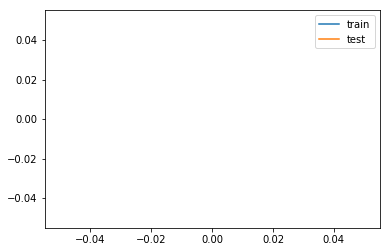

In [16]:
plt.figure(figsize=(12,5))
for i in range(2):
    if i == 0:
        if history_prev is None:
            continue
        else:
            hist = history_prev
    else:
        hist = history
        
    loss = hist.history["loss"]
    val_loss = hist.history["val_loss"]
    epochs = range(1, len(loss) +1)
    ax = plt.subplot(1,2,1+i)
    ax.plot(epochs, loss, label="train")
    ax.plot(epochs, val_loss, label="validation")
    ax.set_xticks(epochs, epochs)
    ax.set_ylim(0.0,1.0)
    ax.legend()

plt.show()

In [ ]:
#Save

In [ ]:
model.save_weights('conv1d.h5')
with open('conv1d.json', 'w') as f:
    f.write(model.to_json())

In [ ]:
#Evaluation

In [ ]:
y_pred = []
for ix in range(testX_n.shape[0]):
    y_pred.append(model.predict([np.expand_dims(testX_n[ix,:].reshape(250,2),0)]))

In [ ]:
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score

y_pred = np.array(y_pred).reshape(-1,250)
print(y_pred.shape, testY_n.shape)
print("Test error analysis:")
print("Explained variance score:", explained_variance_score(testY_n, y_pred))
print("MAE error:", mean_absolute_error(testY_n, y_pred))
print("MSE error:", mean_squared_error(testY_n, y_pred))
print("R2 score:", r2_score(testY_n, y_pred))

In [ ]:
# Visualize

In [ ]:
ix=10
print(np.expand_dims(testX_n[ix,:], axis=0).shape)

plt.figure(figsize=(12,9))
ax = plt.subplot(3,1,1)
ax.plot(testX_0_n[ix,:].reshape(1,-1).T, c="g", label="PPG")
ax.legend()

ax = plt.subplot(3,1,2)
ax.plot(testX_1_n[ix,:].reshape(1,-1).T, c="g", label="ECG")
plt.legend()


ax = plt.subplot(3,1,3)
ax.plot(model.predict(np.expand_dims(testX_n[ix,:], axis=0)).T, label="pred_ART")
ax.plot(testY_n[ix,:].reshape(1,-1).T, c="g", label="real_ART")
ax.legend()

plt.show()